______
<img style="float: right;" src="./images/headerlogo.png">
## Google Earth Engine (GEE) Tutorial

###  Feature Extraction
_____

Extracting spectral or spatial information is not a uncommon task during processing of remotely sensed images because these information may improve classification results capturing additional information than spectral bands. <br>
In the following lines of code, we will extract vegetation indices and textural features. 

#### Vegetation indices

GEE has implemented a *normalizedDifference* function to compute the normalized difference between two bands. This function is used to compute the normalized vegetation index - [NDVI] (https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index). Given *b1* and  *b2*, 

*normalizedDifference(b1,b2)* calculates *(b1 − b2 / (b1 + b2)*. 

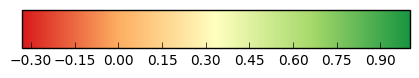

In [10]:
import ee
import numpy as np
from IPython.display import Image
from IPython.display import display
import pprint

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm, colorbar
from matplotlib import colors as mcolors

ee.Initialize()
image = ee.Image('users/rosamaguilar/tutorial/subset')
# compute the normalized vegetation index using Infrared and red bands
# NDVI = (NIR - red) / (NIR + red)

ndvi = image.normalizedDifference(['b7', 'b5']).rename(['NDVI'])
# ndvi.getInfo() will give a generic min and max of a normalized index datatype but not the real min and max for this image
# A reducer will give those values
mymax = ndvi.reduceRegion(
  reducer = ee.Reducer.minMax(),
  geometry = ndvi.geometry(),
  scale = 2,
  maxPixels = 10000000).getInfo()
#print(mymax)

# define a palette for visualization, greenest color imply higher values
palette =','.join(['d7191c','fdae61','ffffbf','a6d96a','1a9641'])

img1 = Image(url=ndvi.getThumbUrl({'min':mymax['NDVI_min'], 'max': mymax['NDVI_max'], 'palette':palette}))
display(img1)

# create the color bar

# format the pallete 
palette = palette.split(',')
color_list = list(map(lambda x: '#'+x.strip(), palette))
# create a linear segmented colormap with the specified name from a given sequence of colors 
cmap_obj = LinearSegmentedColormap.from_list('palette', color_list)
# apply a linear normalization to the palette using min and max
cnorm = mcolors.Normalize(vmin=mymax['NDVI_min'], vmax=mymax['NDVI_max']) 
# draw a bar
fig = plt.figure(figsize=(5, 0.5))
ax = plt.subplot(111)
cbar = colorbar.ColorbarBase(ax, norm=cnorm, orientation='horizontal', cmap=cmap_obj)
plt.show();

Other vegetation indices may involve additional computation rather than a normalized difference.<br>
For those cases, GEE includes the *expression* function. The following example calculate the *Soild Adjusted Vegetation Index - SAVI*

{'bands': [{'crs': 'EPSG:32630',
            'crs_transform': [2.0009777545928955,
                              0.0,
                              260323.03819620793,
                              0.0,
                              -2.0009777545928955,
                              1346325.1740949643],
            'data_type': {'max': 196605.0,
                          'min': -196605.0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'dimensions': [686, 563],
            'id': 'SAVI'}],
 'type': 'Image'}
{'SAVI_max': 1.4998188186979104, 'SAVI_min': -0.49665749115218244}


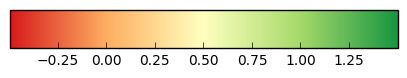

In [11]:
# SAVI veg_index <- (1+L)*(y[,nir] - y[,red])/(y[,nir] + y[,red] + L)
# L=0.5
image = ee.Image('users/rosamaguilar/tutorial/subset')
savi = image.expression (
  '( 1.5)* (NIR -R)/(NIR + R + 0.5)', {
   'NIR': image.select('b7'),
   'R': image.select('b5'), 
  }).rename(['SAVI'])

pprint.pprint(savi.getInfo())
palette =','.join(['d7191c','fdae61','ffffbf','a6d96a','1a9641'])
# A reducer to get minimum and maximum  values
mymax = savi.reduceRegion(reducer = ee.Reducer.minMax(),geometry = savi.geometry(),scale = 2, maxPixels = 10000000).getInfo()
print(mymax)
img1 = Image(url=savi.getThumbUrl({'min':mymax['SAVI_min'], 'max': mymax['SAVI_max'], 'palette':palette}))
display(img1)

# create the color bar
palette = palette.split(',')
color_list = list(map(lambda x: '#'+x.strip(), palette))
cmap_obj = LinearSegmentedColormap.from_list('palette', color_list)
cnorm = mcolors.Normalize(vmin=mymax['SAVI_min'], vmax=mymax['SAVI_max']) 
fig = plt.figure(figsize=(5, 0.5))
ax = plt.subplot(111)
cbar = colorbar.ColorbarBase(ax, norm=cnorm, orientation='horizontal', cmap=cmap_obj)
plt.show();


You may try to compute the *TCARI - Transformed Chlorophyll Absorption in Reflectance Index* <br>
Its formula is: TCARI = 3*((red_edge-red)-0.2*(red_edge-green)*(red_edge/red))</i>


#### Textural Features 


Textural features provide information about the spatial distribution of the spectral information in an image band. One of the most common methods to compute textural features uses the [*Gray Level Co-occurrence Matrix (GLCM)*](http://haralick.org/journals/TexturalFeatures.pdf).  Textural features may be not intuitive to the human eye but several studies have showed their contribution in image classification. <br> 

In GEE the function *glcm* compute 18 textural features per band image. <br>
The following parameters can be specified: 

+ *size*:  the inter-pixel distance to used in the calculation. Defaul value is 1.
+ *kernel*: defines the offsets to use in the calculation. The default value is a 3x3 square kernel with four directions offsets:   (-1, -1), (0, -1), (1, -1) and (-1, 0). Figure below illustrate the default kernel.
+ *average*: </b> indicates if the bands resulting of the four direction calculations will be averaged. Default values is True.
![alt text](./images/kernel_textures_2.png)

 



In [12]:
glcm = image.glcmTexture()
# print the band names
print(glcm.bandNames().getInfo())

['b1_asm', 'b1_contrast', 'b1_corr', 'b1_var', 'b1_idm', 'b1_savg', 'b1_svar', 'b1_sent', 'b1_ent', 'b1_dvar', 'b1_dent', 'b1_imcorr1', 'b1_imcorr2', 'b1_maxcorr', 'b1_diss', 'b1_inertia', 'b1_shade', 'b1_prom', 'b2_asm', 'b2_contrast', 'b2_corr', 'b2_var', 'b2_idm', 'b2_savg', 'b2_svar', 'b2_sent', 'b2_ent', 'b2_dvar', 'b2_dent', 'b2_imcorr1', 'b2_imcorr2', 'b2_maxcorr', 'b2_diss', 'b2_inertia', 'b2_shade', 'b2_prom', 'b3_asm', 'b3_contrast', 'b3_corr', 'b3_var', 'b3_idm', 'b3_savg', 'b3_svar', 'b3_sent', 'b3_ent', 'b3_dvar', 'b3_dent', 'b3_imcorr1', 'b3_imcorr2', 'b3_maxcorr', 'b3_diss', 'b3_inertia', 'b3_shade', 'b3_prom', 'b4_asm', 'b4_contrast', 'b4_corr', 'b4_var', 'b4_idm', 'b4_savg', 'b4_svar', 'b4_sent', 'b4_ent', 'b4_dvar', 'b4_dent', 'b4_imcorr1', 'b4_imcorr2', 'b4_maxcorr', 'b4_diss', 'b4_inertia', 'b4_shade', 'b4_prom', 'b5_asm', 'b5_contrast', 'b5_corr', 'b5_var', 'b5_idm', 'b5_savg', 'b5_svar', 'b5_sent', 'b5_ent', 'b5_dvar', 'b5_dent', 'b5_imcorr1', 'b5_imcorr2', 'b5_ma

<b>Visualize textural features </b>

Minimun and maximum values of each band must be explored to set the visualization parameters.<br>
To find those values we will apply a <i>reducer</i> over the whole image. <br>


In [13]:
# Compute min and max of b5 correlation 
print(glcm.select('b5_corr').reduceRegion(ee.Reducer.minMax()).getInfo())

{'b5_corr_min': -0.8908995196420346, 'b5_corr_max': 0.4371934208813961}


In [14]:
# lets define a new palette:
#palette =','.join(['d7191c','5120b2'])
palette =','.join(['d7191c','ffffbf'])
Image(url=glcm.select('b5_corr').getThumbUrl({'min':-0.9, 'max': 0.43, 'palette':palette}))

In [15]:
# Visualize Entropy of the Infrared band (b7):
min_max = glcm.select('b7_ent').reduceRegion(ee.Reducer.minMax()).getInfo()
print(glcm.select('b7_ent').reduceRegion(ee.Reducer.minMax()).getInfo())
min = min_max['b7_ent_min']
max = min_max['b7_ent_max']
Image(url=glcm.select('b7_ent').getThumbUrl({'min': min, 'max': max, 'palette':palette}))

{'b7_ent_max': 2.2821740957339185, 'b7_ent_min': 1.0397207708399179}


In [16]:
# Visualize Homogeneity (Inverse Different Moment) of the green band (b3):
palette =','.join(['d7191c','ffffbf'])
min_max = glcm.select('b3_idm').reduceRegion(ee.Reducer.minMax()).getInfo()
print(glcm.select('b3_idm').reduceRegion(ee.Reducer.minMax()).getInfo())
min = min_max['b3_idm_min']
max = min_max['b3_idm_max']
Image(url=glcm.select('b3_idm').getThumbUrl({'min': min, 'max':  max, 'palette':palette}))

{'b3_idm_max': 0.3987935532418258, 'b3_idm_min': 6.894451501972257e-07}
